In [1]:
import os
import zipfile
import tensorflow as tf
import numpy as np
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from datasets import load_dataset
import os
import shutil
from PIL import Image
import glob

2025-05-16 09:55:38.368722: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-16 09:55:38.378668: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747368638.390058    9397 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747368638.393805    9397 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747368638.402638    9397 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [20]:
from huggingface_hub import notebook_login

notebook_login()

In [2]:
data = load_dataset("MadanKhatri/house_problem_images")

In [3]:
ex = data['train'][100]
ex

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=686x386>,
 'label': 3}

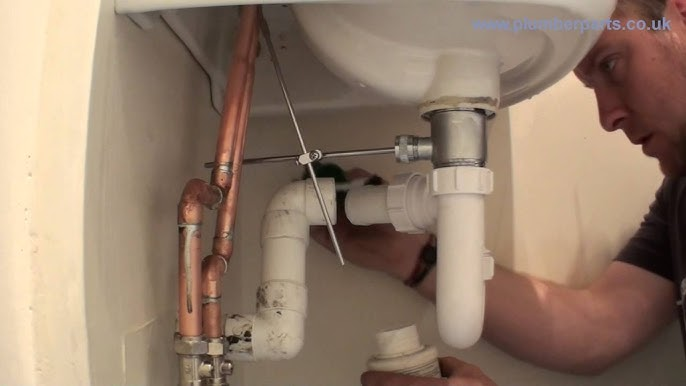

In [4]:
image = ex['image']
image

In [5]:
labels = data['train'].features['label']
labels

ClassLabel(names=['builder', 'electrician', 'others', 'plumber'], id=None)

In [6]:
labels.int2str(ex['label'])

'plumber'

In [7]:
from evaluate import load

metric = load("accuracy")

In [8]:
data

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1758
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 311
    })
})

In [9]:
labels = data["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

In [10]:
from transformers import ViTFeatureExtractor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

/home/madan/.pyenv/versions/pyenvs/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [11]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
train_transforms = Compose(
        [
            RandomResizedCrop(feature_extractor.size['height']), # Access the height or width key
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(feature_extractor.size['height']), # Access the height or width key
            CenterCrop(feature_extractor.size['height']), # Access the height or width key
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [12]:
train_ds = data['train']
val_ds = data['test']

In [13]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

In [14]:
train_ds[0]

{'image': <PIL.Image.Image image mode=RGB size=3850x2891>,
 'label': 1,
 'pixel_values': tensor([[[-0.4118, -0.4118, -0.4196,  ..., -0.9529, -0.9529, -0.8745],
          [-0.4118, -0.4039, -0.4118,  ..., -0.9451, -0.9451, -0.9294],
          [-0.4118, -0.4039, -0.3961,  ..., -0.9451, -0.9608, -0.9686],
          ...,
          [-0.4745, -0.4196, -0.4196,  ..., -0.3412, -0.4118, -0.3020],
          [-0.4275, -0.4118, -0.4667,  ..., -0.2706, -0.3490, -0.1765],
          [-0.3804, -0.4118, -0.5216,  ..., -0.2157, -0.2000, -0.1843]],
 
         [[-0.4510, -0.4588, -0.4588,  ..., -0.9608, -0.9529, -0.8902],
          [-0.4510, -0.4588, -0.4510,  ..., -0.9529, -0.9529, -0.9373],
          [-0.4510, -0.4510, -0.4510,  ..., -0.9529, -0.9686, -0.9765],
          ...,
          [-0.5059, -0.4588, -0.4667,  ..., -0.3647, -0.4275, -0.3333],
          [-0.4588, -0.4588, -0.5137,  ..., -0.3098, -0.3804, -0.2235],
          [-0.4196, -0.4431, -0.5451,  ..., -0.2627, -0.2392, -0.2392]],
 
         [[-

In [15]:
from transformers import ViTForImageClassification
model_name_or_path = 'google/vit-base-patch16-224-in21k'
model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='finetuned-occupations',
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy="steps",
    num_train_epochs=10,  # Updated from 9 to 10
    fp16=True,
    save_steps=100,
    eval_steps=100,
    logging_steps=10,
    learning_rate=2e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=True,
    report_to='tensorboard',
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_dir='./logs',
    seed=42
)

In [17]:
import numpy as np

# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [18]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

In [21]:
from transformers import Trainer
trainer = Trainer(
    model,
    training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

/tmp/ipykernel_9397/963735583.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [22]:
train_results = trainer.train()
# rest is optional but nice to have
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/home/madan/.pyenv/versions/pyenvs/lib/python3.10/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
100,0.589300,0.514178,0.842444
200,0.424800,0.370143,0.868167
300,0.247400,0.361343,0.884244
400,0.178300,0.363787,0.881029
500,0.129700,0.382830,0.897106
600,0.151200,0.393535,0.900322
700,0.085600,0.382469,0.903537
800,0.061900,0.408207,0.900322
900,0.056000,0.346442,0.900322
1000,0.063600,0.332707,0.919614


/home/madan/.pyenv/versions/pyenvs/lib/python3.10/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/madan/.pyenv/versions/pyenvs/lib/python3.10/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/madan/.pyenv/versions/pyenvs/lib/python3.10/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/madan/.pyenv/versions/pyenvs/lib/python3.10/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/madan/.pyenv/versions/pyenvs/lib/python3.10/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

***** train metrics *****
  epoch                    =         10.0
  total_flos               = 1268772033GF
  train_loss               =       0.2208
  train_runtime            =   0:08:59.74
  train_samples_per_second =       32.571
  train_steps_per_second   =        2.038


In [23]:
metrics = trainer.evaluate()
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

/home/madan/.pyenv/versions/pyenvs/lib/python3.10/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


***** eval metrics *****
  epoch                   =       10.0
  eval_accuracy           =     0.9196
  eval_loss               =     0.3327
  eval_runtime            = 0:00:05.61
  eval_samples_per_second =     55.409
  eval_steps_per_second   =      3.563


In [24]:
kwargs = {
    "finetuned_from": model.config._name_or_path,
    "tasks": "image-classification",
    "dataset": 'house_problem_images',
    "tags": ['image-classification'],
}

if training_args.push_to_hub:
    trainer.push_to_hub('🍻 cheers', **kwargs)
else:
    trainer.create_model_card(**kwargs)

In [25]:
# Load model directly
from transformers import AutoImageProcessor, AutoModelForImageClassification

processor = AutoImageProcessor.from_pretrained("MadanKhatri/finetuned-occupations")
model = AutoModelForImageClassification.from_pretrained("MadanKhatri/finetuned-occupations")

preprocessor_config.json:   0%|          | 0.00/353 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/home/madan/.pyenv/versions/pyenvs/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/818 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

In [31]:
from PIL import Image

# Prepare image for the model
image = Image.open("test/test5.png").convert("RGB")  # Open image and convert to RGB
encoding = feature_extractor(image, return_tensors="pt")  # Use your feature_extractor
print(encoding.pixel_values.shape)

torch.Size([1, 3, 224, 224])


In [32]:
import torch

# forward pass
with torch.no_grad():
  outputs = model(**encoding)
  logits = outputs.logits

In [33]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: plumber
